## Cel·la de prova

ha de sortir una ruta que inclogui envs/myenv

# Crear blueprint

Per verificar que datasets.ods i el notebook estan a la llista

In [1]:
import os, sys
print("Python executable:", sys.executable)     # mostra el Python que corre (ha de ser el env activat)
print("Directori de treball:", os.getcwd())    # carpeta del repo
print("Llistat d'arxius a la carpeta:")
for f in sorted(os.listdir('.')):
    print(" -", f)

Python executable: c:\Users\UX433\miniconda3\envs\myenv\python.exe
Directori de treball: c:\Users\UX433\OneDrive\Escritorio\networkalignment
Llistat d'arxius a la carpeta:
 - .git
 - A2_blueprint.npy
 - A_test_equiv.npy
 - C-el_k4_Synthetic- No groups - Simoultenously.ipynb
 - Hs_base0.npy
 - Hs_base1.npy
 - Hs_synthetic_paper.npy
 - L_latent_from_pq.npy
 - L_latent_repo_exact_errors.npy
 - Matriz_epochs_A.pickle
 - Syntetic_succesive_tot_0.pickle
 - codienbrut.ipynb
 - crear_blueprint.ipynb
 - datasets.ods
 - energies_base0.npy
 - energies_base1.npy
 - energy_pipeline_summary.npy
 - environment.yml
 - synthetic_paper.npy
 - synthetic_repo_errors.npy


In [2]:
import itertools
import pickle
import matplotlib.pyplot as plt
import numpy as np
import math
import random
import os
import time
from numba import jit, njit
from numba.types import bool_, int_, float32
from math import comb
from copy import deepcopy
from tqdm import tqdm
import networkx as nx
import pandas as pd
from collections import defaultdict
from itertools import permutations

### Llegir fulls de càlcul 

In [3]:
### Open the files
fulls = 8
#n_grupo = 4 - ara no estic fent servir grups

d = {} #crea un diccionari per emmagatzemar DataFrames(taules de memòria)
D = "Dataset" #prefix del nom de les fulles — al excel es diuen Dataset1, Dataset2, ...
for i in range(0,fulls): #recorro 0...7
    d["group" + str(i)] = pd.read_excel("datasets.ods", sheet_name=D+str(i+1)) #el que al diccionari serà gorup 0, sera el meu Dataset1
    # hem assignat al diccionari: d["group0"] = <taula Dataset1> 
    print('Read:',i, 'size', d["group" + str(i)].shape) #volem imprimir el nre de files i columnes

Read: 0 size (227, 183)
Read: 1 size (227, 183)
Read: 2 size (227, 183)
Read: 3 size (227, 183)
Read: 4 size (227, 183)
Read: 5 size (227, 183)
Read: 6 size (227, 183)
Read: 7 size (227, 183)


### Passar a matriu i binaritzem

Consideracions a tenir en compte. Primer, treiem les 3 primeres files i columnes de cada full de càlcul perquè a l'excel contenen etiquetes, no dades. En segon lloc, tenim 227 diles i 183 columnes. El que fem és forçar una matriu quadrada nre.filesxnre.files, de manera que, com la matriu inicial eren zeros, copio les columnes existets i deixo la resta plenes de zeros. Això podria donar error. NOTA: Els datasets compten la primera columna com títols.

In [4]:
## Hipermatrix M with the data (Only the synapses) 
rows = d["group" + str(i)].shape[0] - 3
columns = d["group" + str(i)].shape[1] - 3 #les tres primeres files i columnes no contenen dades

M = np.zeros((fulls,rows,columns))
for i in range(0, fulls):
    Data = d['group' + str(i)]
    M[i,:,:] = Data.iloc[3:,3:]
    
## Since we work with same number of nodes, we want them equal and square (zeros when no connections)
M_square = np.zeros((fulls, rows, rows))#creo matriu quadrada
M_square[:,:, 0:columns] = M[:,:,:] #copies les columnes existents (0..179) per deixar zeros en les restants (180..223).

## Binarization: No weights
#Lo queremos BINARIO, ignorando su peso (Luego pensar cómo se haría con el peso)
M_square_bin = np.zeros((fulls,rows,rows))
for i in range(fulls):
    for j in range(rows):
        for k in range(columns):
            if (M[i,j,k] >= 1):
                M_square_bin[i,j,k] = 1
                
Nx = rows # Number of nodes (we imposed rows == columns)


### Comprovació de l’estructura dels fulls de càlcul

Vull assegurar-me de que la neteja dels Datasets (primeres 3 files i columnes) està feta correctament. Nota: Els Datasets prenen la primera fila com un Títol  ('Pre', en aquest cas). Per tant, realment n'estic esborrant 4.

In [5]:
# inspecció ràpida d'un full de càlcul (group 7-->Dataset8)
df7 = d['group7']
print("Shape original group7:", df7.shape)
print("\nColumn names (first 12):\n", df7.columns[:12])
print("\nPrimeres 8 files i 8 columnes (sense transformar):")
print(df7.iloc[:8, :8])

Shape original group7: (227, 183)

Column names (first 12):
 Index(['Unnamed: 0', 'Unnamed: 1', 'Unnamed: 2', 'Pre', 'Unnamed: 4',
       'Unnamed: 5', 'Unnamed: 6', 'Unnamed: 7', 'Unnamed: 8', 'Unnamed: 9',
       'Unnamed: 10', 'Unnamed: 11'],
      dtype='object')

Primeres 8 files i 8 columnes (sense transformar):
  Unnamed: 0 Unnamed: 1 Unnamed: 2      Pre Unnamed: 4 Unnamed: 5 Unnamed: 6  \
0        NaN        NaN        NaN  Sensory        NaN        NaN        NaN   
1        NaN        NaN        NaN     ADFL       ADFR       ADLL       ADLR   
2        NaN        NaN        NaN      NaN        NaN        NaN        NaN   
3       Post    Sensory       ADFL        0          0          0          0   
4        NaN        NaN       ADFR        0          0          0          0   
5        NaN        NaN       ADLL        0          0          0          0   
6        NaN        NaN       ADLR        0          0          0          0   
7        NaN        NaN       AFDL      

## Escollir quin és el dataset A2

Sabem (per la informació del paper) que A2 té aproximadament 2186 arestes (edges), comprovem si el Dataset8 concorda amb aquestes dades, mirem cada dataset (recordem que group0-->Dataset1, group1-->Dataset2, ...).

NOTA: A més sospitem que el Dataset8 és el que conté les dades de A2 perquè al repo de la Teresa es pren A2 com a Blueprint fent M_square_bin[-1] que correspon a l'últim element de l'array, és a dir, M_square_bin[7], que correspon a group7--> Dataset8

### Coprovació de que Dataset8 correspon a A2

In [6]:
# Veure quants edges té cada dataset
for i in range(8):
    print(i, M_square_bin[i].sum())

0 775.0
1 986.0
2 1012.0
3 1136.0
4 1515.0
5 1525.0
6 2202.0
7 2186.0


## Guardar A2 com blueprint

Volem crear i guardar el blueprint A2 (Dataset8 = group7 = M_square_bin[-1])


In [7]:
#Seleccionem A2, és a dir, el dataset8
A2=M_square_bin[-1].copy()
#Fem comprovacions
print("A2 creat")
print("Files i columnes A2", A2.shape)
print("Arestes", int(A2.sum()))
#guardem
np.save("A2_blueprint.npy", A2)
print("Guardat com A2_blueprint")

A2 creat
Files i columnes A2 (224, 224)
Arestes 2186
Guardat com A2_blueprint


# Generar xarxes amb error

Dues maneres, fixar un nombre d'errors (com es fa al codi de la Teresa) o fer servir p i q (probabilitats de copiar malament un link/no-link). Farem totes dues

### ESBORRAR AIXÒ: Veure d'on sortien els errors q feia servir Teresa

In [8]:
L = np.load("A2_blueprint.npy")
Nx = L.shape[0]
edges = int(L.sum())
zeros = Nx*Nx - edges
e_error = 327
z_error = 327
q_equiv = e_error / edges
p_equiv = z_error / zeros
print("edges", edges, "zeros", zeros)
print("q_equiv =", q_equiv)
print("p_equiv =", p_equiv)

edges 2186 zeros 47990
q_equiv = 0.1495882891125343
p_equiv = 0.00681391956657637


Hem vist que p i q del repositori son practicament els mateixos del paper

### Càlcul de nombre d'errors equivalents per p i q

In [9]:
# Carrega el blueprint A2 desat
L = np.load("A2_blueprint.npy")

Nx = L.shape[0]

print("Blueprint A2 carregat correctament.")
print("Mida:", L.shape)
print("Nombre d'enllaços (1’s):", int(L.sum()))


Blueprint A2 carregat correctament.
Mida: (224, 224)
Nombre d'enllaços (1’s): 2186


In [10]:
# Errors deduits dels valors del paper
edges_A2 = L.sum()
zeros_A2 = Nx*Nx - edges_A2

q_paper = 0.15
p_paper = 0.007

errors_esborrar = int(q_paper * edges_A2)
errors_crear = int(p_paper * zeros_A2)

print(errors_esborrar, errors_crear)


327 335


No són exactament els mateixos, suposo que això es deu a què al repo es fan servir p i q que no quadren exactament amb els del paper. 

(Esborrar això) ara faré el mateix però amb els p i q que he deduit del codi de la teresa, per veure si em surt el mateix nre, d'errors que ella ha fet servir (327,327) i comprovar validesa de l'anterior

In [11]:
# Errors deduits dels valors del paper
edges_A2 = L.sum()
zeros_A2 = Nx*Nx - edges_A2

errors_esborrar_teresa = int(q_equiv * edges_A2)
errors_crear_teresa = int(p_equiv * zeros_A2)

print(errors_esborrar_teresa, errors_crear_teresa)


327 327


Sí, el nombre d'errors quadra

# Generar xarxes amb nombre d'errors

Ara estem generant xarxes com es feia al repositori, amb el mateix nombre d'errors exacte

In [12]:
# === Generar xarxes amb errors exactes (estil del repo) ===

K = 2             # nombre de xarxes a generar
e_error = 327       # errors esborrant enllaços
z_error = 327       # errors creant enllaços

# Carregar blueprint si cal
if 'L' not in globals():
    print("No hi ha L a la memòria, carregant A2_blueprint.npy ...")
    L = np.load("A2_blueprint.npy")

Nx = L.shape[0]
print("Blueprint A2 carregat: shape", L.shape, "edges:", int(L.sum()))

# Preparar output
A_repo = np.zeros((K, Nx, Nx), dtype=int)
rng = np.random.default_rng(42)  # llavor fixa

edges_total = int(L.sum())
zeros_total = Nx * Nx - edges_total

print("Edges A2:", edges_total, "Zeros A2:", zeros_total)

# Comprovacions
if e_error > edges_total:
    raise ValueError(f"e_error ({e_error}) > nombre d'enllaços ({edges_total})")
if z_error > zeros_total:
    raise ValueError(f"z_error ({z_error}) > nombre de zeros ({zeros_total})")

for m in range(K):
    A = L.copy().astype(int)
    A_flat = A.reshape(Nx*Nx)

    ones_idx = np.where(A_flat == 1)[0]
    zeros_idx = np.where(A_flat == 0)[0]

    flip_ones = rng.choice(ones_idx, size=e_error, replace=False)
    flip_zeros = rng.choice(zeros_idx, size=z_error, replace=False)

    A_flat[flip_ones] = 0
    A_flat[flip_zeros] = 1

    A = A_flat.reshape(Nx, Nx)
    A_repo[m] = A

    errors_removed = edges_total - np.sum((A == 1) & (L == 1))
    errors_added = np.sum((A == 1) & (L == 0))

    print(f"Xarxa {m}: Edges = {int(A.sum())}, Errors esborrant = {errors_removed}, Errors creant = {errors_added}")

# Guardar a disc
out_name = "synthetic_repo_errors.npy"
np.save(out_name, A_repo)
print("\nGuardades les xarxes amb errors exactes a:", out_name)


Blueprint A2 carregat: shape (224, 224) edges: 2186
Edges A2: 2186 Zeros A2: 47990
Xarxa 0: Edges = 2186, Errors esborrant = 327, Errors creant = 327
Xarxa 1: Edges = 2186, Errors esborrant = 327, Errors creant = 327

Guardades les xarxes amb errors exactes a: synthetic_repo_errors.npy


# Generar xarxes amb p i q

In [ ]:
num_networks = 2
A_test = np.zeros((num_networks, Nx, Nx))

p = p_paper
q = q_paper

np.random.seed(1)

for k in range(num_networks):
    A_copy = L.copy()
    for i in range(Nx):
        for j in range(Nx):
            if L[i,j] == 1:
                # enllaç existent -> pot ser esborrat
                if np.random.rand() < q:
                    A_copy[i,j] = 0
            else:
                # posició buida -> pot crear-se un fals
                if np.random.rand() < p:
                    A_copy[i,j] = 1
    A_test[k,:,:] = A_copy
#posar .copy per asegurar q les a.test son diferents mirar a0 i a1 son diferents
print("Xarxes generades amb p i q del paper:")
print(A_test.shape)
np.save("synthetic_paper.npy", A_test)


Xarxes generades amb p i q del paper:
(2, 224, 224)


Ara volem comprovar el nombre d'enllaços que s'han creat (p·zeros ≈ 0.007·48000 ≈ 330–350 nous) i esborrat (q·edges ≈ 0.15·2186 ≈ 327–330 enllaços)

In [14]:
# Comprovació del nombre d’enllaços final
original_edges = int(L.sum())
zeros_original = Nx*Nx - original_edges

print("Blueprint (A2) edges:", original_edges)
print("Blueprint zeros:", zeros_original)

for k in range(num_networks):
    edges_new = int(A_test[k].sum())
    print(f"\nXarxa {k}:")
    print("  Edges:", edges_new)

    # errors equivalents
    errors_esborrats = original_edges - np.sum((A_test[k] == 1) & (L == 1))
    errors_creats = np.sum((A_test[k] == 1) & (L == 0))

    print("  Errors esborrant:", errors_esborrats)
    print("  Errors creant:", errors_creats)


Blueprint (A2) edges: 2186
Blueprint zeros: 47990

Xarxa 0:
  Edges: 2207
  Errors esborrant: 320
  Errors creant: 341

Xarxa 1:
  Edges: 2174
  Errors esborrant: 333
  Errors creant: 321


## Funcions d'energia

Aquí enganxo les funcions d'energia del repositori del paper, del notebook "C-el_k4_Synthetic-No groups...", ja que son les mateixes que he de fer servir.

No considerem grups, per tant:

In [15]:
n_groups = 1 #considerem que els nodes pertanyen a un únic grup
start_groups = np.zeros(1) #indica on comença cada grup
end_groups = np.zeros(1) + Nx #indica on acaba
size_groups = np.zeros(1) + Nx

start_groups, end_groups, size_groups = start_groups.astype(int), end_groups.astype(int), size_groups.astype(int)

Aquestes son les funcions d'energia tal qual com estan al repo del paper

In [16]:
# @jit(nopython = True)
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
#calcula l’energia H com a suma de dues log-Beta (usant lgamma) i torna - (H1 + H0) 
    
    print("\n---- DINS HAMILTONIAN ----")
    print("Edges_NoL:", Edges_NoL)
    print("Edges_L:", Edges_L)
    print("overlap_0:", overlap_0)
    print("overlap_1:", overlap_1)
    print("alpha:", alpha, "beta:", beta)
    
    
    
    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta
    
    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta
    
    #  [ math.lgamma(n+1) == log(n!) ]
    H1 = math.lgamma(A_1)+ math.lgamma(B_1) - math.lgamma(C_1) 
    H0 = math.lgamma(A_0)+ math.lgamma(B_0) - math.lgamma(C_0) 
    
    H = -(H1 + H0)
    print("A_1,B_1,C_1 =", A_1, B_1, C_1)
    print("A_0,B_0,C_0 =", A_0, B_0, C_0)
    return H

    
    
# @jit(nopython=True)
def overlap_total_prob(L_f, A_f, P_inv_f):
    #corre la blueprint L_f (de mida Ny x Nx) i per cada observació k suma 2 quantitats:

    print("\n=== DINS overlap_total_prob ===")
    print("L_f shape:", L_f.shape)
    print("A_f shape:", A_f.shape)
    print("P_inv_f shape:", P_inv_f.shape)

    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    
    ovlp_0 = np.zeros((K)) #nombre de posicions on L==0 i A_k també és 0.
    ovlp_1 = np.zeros((K)) #nombre de posicions on L==1 i A_k (mapejat per P_inv) també és 1.
    for k in range(0,K):
        print(f"\n-- Xarxa k = {k} --")
        for f in range(0,Ny): 
            for c in range(0,Nx):
                p_f=int(P_inv_f[k,f])
                p_c=int(P_inv_f[k,c])  
                
                if f < 3 and c < 3:    # evitar imprimir massa
                    print(f"f={f}, c={c}  ->  mapped to (p_f={p_f}, p_c={p_c})")


                valor_L, valor_A = L_f[f,c], A_f[k,p_f,p_c]

                if f < 3 and c < 3:
                    print(f"L={valor_L}, A={valor_A}")
                
                ovlp_0[k] = ovlp_0[k] + (1-valor_L)*(1-valor_A )
                ovlp_1[k] = ovlp_1[k] + valor_L*valor_A
                
    print("SUMA FINAL ovlp_0:", sum(ovlp_0))
    print("SUMA FINAL ovlp_1:", sum(ovlp_1))

    ovlp_1 = int(sum(ovlp_1)) #potser els que ens interesa és el de cada xarxa, no la suma
    ovlp_0 = int(sum(ovlp_0))
    return ovlp_0, ovlp_1


#@jit(nopython=True) # The blueprint is the average of the observations (taking into account the mapping)  
def L_wiring(A_f, P_inv_f):
    #reconstrueix una blueprint entrenada L_new_f, prenent per cada observació la majoria mitjana
    print("\n=== DINS L_wiring ===")
    print("A_f shape:", A_f.shape)
    print("P_inv_f shape:", P_inv_f.shape)
    Nx = A_f.shape[1]
    Ny = A_f.shape[2]
    K = A_f.shape[0]
    L_new_f = np.zeros((Nx,Ny))
    
    for i in range(0,Nx):
        for j in range(0,Ny):
            for k in range(0,K):
        
                p1 = int(P_inv_f[k,i]) # Mapping of the observations
                p2 = int(P_inv_f[k,j]) # Mapping of the observations
                L_new_f[i,j] += A_f[k,p1,p2]
            valor_lnew=1/K* L_new_f[i,j]
            L_new_f[i,j] = round( valor_lnew ) 
            # If valor_lnew = 0, L=0 (we could establish L=1, but it is more probable to not have a connection)
            if i < 3 and j < 3:
                print(f"[{i},{j}] sum = {L_new_f[i,j]}")
    return L_new_f


#### Some algorithm for sorting
#partition i quicksort són la implementació in-place del quicksort per ordenar nodes segons grau.
#També s’ordenen les etiquetes (array etiquetas) per mantenir el mapping.
#@jit(nopython=True)
def partition(array,  etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot] 

    return pivot
#@jit(nopython=True)
def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end: #To end
        return
    pivot = partition(array,  etiquetas, begin, end)
    
    #Order right and left
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array,  etiquetas, pivot+1, end)
    
#@njit 
# We inizialise the algorithm sorting by node degree, but also taking into account the group labels
def permu_groups(L_f, A_f, start_f): 
    #calcula el grau (nombre de connexions) per cada node a L_f i a cada A_f[k].
    #ordena nodes per grau i després reordena segons start_f (grups), i construeix P_f (mapping L->A) i P_inv_f (A->L).
    print("\n=== DINS permu_groups ===")
    print("L_f shape:", L_f.shape)
    print("A_f shape:", A_f.shape)

    print("start_f:", start_f)

    Nx = L_f.shape[0]
    Ny = L_f.shape[1]
    K = A_f.shape[0]
    N_groups = len(start_f)
    
    
    # Mappings
    P_f = np.zeros((K,Nx)) #Mapping from L to A
    P_inv_f = np.zeros((K,Nx)) #Mapping from A to L
    P_new = np.zeros((K,Nx))
    
    # First we order the blueprint and after the observations
    # Blueprint:
    orden_L=np.zeros((Nx))
    for i in range(Nx):
        b=np.nonzero(L_f[i,:])
        orden_L[i] = b[0].size

    print("Graus L_f (primeres 10):", orden_L[:10])
        
    array_L = np.arange(Nx) #For the labels 
    quicksort(orden_L, array_L)
    
    # Now according to the group label
    array_L_labels = np.zeros((Nx))
    group_number = np.zeros((N_groups))
    for i in range(Nx):
        n_type = 0
        #Group
        while ( (array_L[i] >= start_f[n_type]) and (n_type < N_groups)):
            n_type += 1
       
        grupo = int(n_type-1)
        g = int(start_f[grupo])
        array_L_labels[g + int(group_number[grupo])] = array_L[i]
        group_number[grupo] += 1

    #Observations: 
    for i in range(0,K):
        orden_A = np.zeros((Nx))
        for i_orden in range(Nx):
            b = np.nonzero(A_f[i,i_orden,:])
            orden_A[i_orden] = b[0].size

        array_A = np.arange(Nx) #For the labels 
        quicksort(orden_A, array_A)
            
        # Now according to the group label
        array_A_labels = np.zeros((Nx))
        group_number = np.zeros((N_groups))
        
        for i_g in range(Nx):
            n_type = 0
            while ( (array_A[i_g] >= start_f[n_type]) and (n_type < N_groups) ):
                n_type += 1

            grupo = int(n_type-1)
            g = int(start_f[grupo])
            array_A_labels[ g + int(group_number[grupo])] = array_A[i_g]
            group_number[grupo] += 1
    

    # Now ordered together both label array  array_L = [0,1,2,3...]
        array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        P_f[i,:] = array_A_labels
        
        for i_inv in range(0,Nx):
            for j_inv in range(0,Ny):
                if (P_f[i,i_inv] == j_inv):
                    P_inv_f[i, j_inv]=i_inv
    
    P_todo = np.zeros((2,K,Nx))
    P_todo[0,:,:] = P_f.copy() 
    P_todo[1,:,:] = P_inv_f.copy()

    return P_todo

 

### Càlcul d'energies amb les xarxes generades amb p i q

Això no funciona, crec que és millor fer-ho com la Teresa, ab nombre d'errors exacte

Carregat blueprint: A2_blueprint.npy shape: (224, 224) edges: 2186
Carregades xarxes p/q: synthetic_paper.npy shape: (2, 224, 224)
start_groups: [0] end_groups: [224]

Calculant permutacions (permu_groups) ...
P_inv_f shape: (2, 224)

Calculant overlaps per xarxa ... (aixo pot trigar una mica segons Nx i K)

Hs per xarxa (synthetic_paper):
  xarxa 0: H = 9068.941469, edges = 2207, ovlp1 = 136, ovlp0 = 45919
  xarxa 1: H = 8959.029714, edges = 2174, ovlp1 = 151, ovlp0 = 45967

Hs guardats a Hs_synthetic_paper.npy

Construint L_latent via L_wiring (majority wiring) ...
L_latent shape, edges: (224, 224) 163
L_latent guardat a L_latent_from_pq.npy
Hs0: [8656.41007387 8737.99724114 8717.74161502 8712.89072285 8611.63810409
 8555.35153353 8620.1170787  8789.77418288 8684.7388454  8840.36028317]
Hs1: [8603.13972735 8601.17135248 8523.66295576 8695.47806405 8693.93909204
 8650.10921652 8475.68331247 8703.60194705 8575.6840082  8668.8767972 ]

H(A2 vs L_latent) = 8629.366888459885


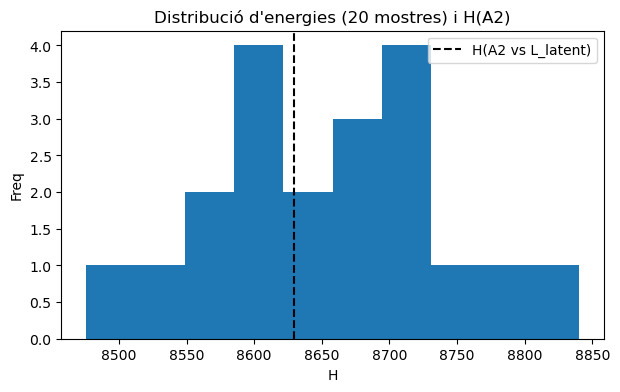


Resum guardat a energy_pipeline_summary.npy


In [17]:

import numpy as np
import math
import os
import matplotlib.pyplot as plt


# Paràmetres i noms fitxers

blueprint_file = "A2_blueprint.npy"
pq_file = "synthetic_paper.npy"    # xarxes generades amb p_paper,q_paper
out_H_file = "Hs_synthetic_paper.npy"
alpha, beta = 5, 2

# Comprovacions fitxers

if not os.path.exists(blueprint_file):
    raise FileNotFoundError(f"No trobat {blueprint_file}. Guarda'l a la carpeta del notebook abans d'executar.")
if not os.path.exists(pq_file):
    raise FileNotFoundError(f"No trobat {pq_file}. Genera'l primer amb p_paper/q_paper.")

# Carregar dades
L = np.load(blueprint_file).astype(int)     # blueprint A2
A_pq = np.load(pq_file).astype(int)         # xarxes generades amb p/q
Nx = L.shape[0]
K = A_pq.shape[0]

print("Carregat blueprint:", blueprint_file, "shape:", L.shape, "edges:", int(L.sum()))
print("Carregades xarxes p/q:", pq_file, "shape:", A_pq.shape)

#Funcions tteresa (sense @jit)
# 
def hamiltonian_prob(Edges_NoL, Edges_L, overlap_0, overlap_1, alpha, beta):
    """Fórmula del repo: retorna H (scalar)"""
    # prints de control (no massa per no saturar)
    #print("hamiltonian_prob inputs -> Edges_NoL:",Edges_NoL,"Edges_L:",Edges_L,"ov0:",overlap_0,"ov1:",overlap_1)
    A_1 = overlap_1 + alpha
    B_1 = (Edges_L - overlap_1 + beta)
    C_1 = Edges_L + alpha + beta

    A_0 = overlap_0 + alpha
    B_0 = (Edges_NoL - overlap_0 + beta)
    C_0 = Edges_NoL + alpha + beta

    H1 = math.lgamma(A_1) + math.lgamma(B_1) - math.lgamma(C_1)
    H0 = math.lgamma(A_0) + math.lgamma(B_0) - math.lgamma(C_0)

    H = -(H1 + H0)
    return H

def overlap_total_prob_per_network(L_f, A_f, P_inv_f):
    """
    Versió que retorna ovlp_0[k], ovlp_1[k] per cada xarxa k.
    Respecta el mapping P_inv_f (forma (K, Nx)).
    """
    K_local = A_f.shape[0]
    ovlp_0 = np.zeros(K_local, dtype=int)
    ovlp_1 = np.zeros(K_local, dtype=int)
    Nx_local = L_f.shape[0]
    # recorrem per xarxa
    for k in range(K_local):
        s0 = 0
        s1 = 0
        for f in range(Nx_local):
            p_f = int(P_inv_f[k, f])
            for c in range(Nx_local):
                p_c = int(P_inv_f[k, c])
                valor_L = int(L_f[f,c])
                valor_A = int(A_f[k, p_f, p_c])
                s0 += (1 - valor_L) * (1 - valor_A)
                s1 += valor_L * valor_A
        ovlp_0[k] = s0
        ovlp_1[k] = s1
    return ovlp_0, ovlp_1

def L_wiring(A_f, P_inv_f):
    """
    Reconstrueix blueprint per majoria (round of mean) tenint en compte P_inv_f.
    Retorna L_new (Nx x Nx)
    """
    K_local = A_f.shape[0]
    Nx_local = A_f.shape[1]
    L_new = np.zeros((Nx_local, Nx_local), dtype=int)
    for i in range(Nx_local):
        for j in range(Nx_local):
            s = 0
            for k in range(K_local):
                p1 = int(P_inv_f[k, i])
                p2 = int(P_inv_f[k, j])
                s += int(A_f[k, p1, p2])
            # mitjana i round
            val = round(s / K_local)
            L_new[i,j] = int(val)
    return L_new

# quicksort/partition del repo (usats per permu_groups)
def partition(array, etiquetas, begin, end):
    pivot = begin
    for i in range(begin+1, end+1):
        if array[i] < array[begin]:
            pivot += 1
            array[i], array[pivot] = array[pivot], array[i]
            etiquetas[i], etiquetas[pivot] = etiquetas[pivot], etiquetas[i]
    array[pivot], array[begin] = array[begin], array[pivot]
    etiquetas[pivot], etiquetas[begin] = etiquetas[begin], etiquetas[pivot]
    return pivot

def quicksort(array, etiquetas, begin=0, end=None):
    if end is None:
        end = len(array) - 1
    if begin >= end:
        return
    pivot = partition(array, etiquetas, begin, end)
    quicksort(array, etiquetas, begin, pivot-1)
    quicksort(array, etiquetas, pivot+1, end)

def permu_groups(L_f, A_f, start_f):
    """
    Implementació com al repo però en Python sense numba.
    Retorna P_todo de forma (2, K, Nx) on:
      P_todo[0] = P_f (map L -> A)
      P_todo[1] = P_inv_f (map A -> L)
    start_f: array amb posicions d'inici de grup (p.ex. [0, Nx])
    """
    Nx_local = L_f.shape[0]
    K_local = A_f.shape[0]
    N_groups = len(start_f)

    # Mappings a omplir
    P_f = np.zeros((K_local, Nx_local), dtype=int)
    P_inv_f = np.zeros((K_local, Nx_local), dtype=int)

    # Ordenació inicial de L per grau
    orden_L = np.zeros(Nx_local, dtype=int)
    for i in range(Nx_local):
        b = np.nonzero(L_f[i,:])[0]
        orden_L[i] = b.size
    array_L = np.arange(Nx_local)
    # ordenem in-place els arrays utilitzant quicksort (com en el repo)
    # quicksort espera arrays mutables
    orden_L_copy = orden_L.astype(float).copy()  # elements numericables
    array_L_copy = array_L.copy()
    quicksort(orden_L_copy, array_L_copy)
    array_L_sorted = array_L_copy  # indices ordenats per grau

    # ara classificar per grups seguint start_f
    array_L_labels = np.zeros(Nx_local, dtype=int)
    group_number = np.zeros(N_groups, dtype=int)
    for idx in range(Nx_local):
        node = array_L_sorted[idx]
        # trobar grup: el grup t tal que start_f[t] <= node < (start_f[t+1] or Nx)
        t = 0
        while (t + 1 < N_groups) and (node >= start_f[t+1]):
            t += 1
        g = int(start_f[t])
        array_L_labels[g + int(group_number[t])] = node
        group_number[t] += 1

    # Observations: per cada A[k] fem el mateix procés
    for k in range(K_local):
        orden_A = np.zeros(Nx_local, dtype=int)
        for i in range(Nx_local):
            b = np.nonzero(A_f[k, i, :])[0]
            orden_A[i] = b.size
        array_A = np.arange(Nx_local)
        orden_A_copy = orden_A.astype(float).copy()
        array_A_copy = array_A.copy()
        quicksort(orden_A_copy, array_A_copy)
        array_A_sorted = array_A_copy

        # ara organitzar per grup en array_A_labels
        array_A_labels = np.zeros(Nx_local, dtype=int)
        group_number = np.zeros(N_groups, dtype=int)
        for idx in range(Nx_local):
            nodeA = array_A_sorted[idx]
            # trobar grup de nodeA
            # es fa comparant el índex ordenat (com en el repo)
            t = 0
            while (t + 1 < N_groups) and (nodeA >= start_f[t+1]):
                t += 1
            g = int(start_f[t])
            array_A_labels[g + int(group_number[t])] = nodeA
            group_number[t] += 1

        # ara posar array_A_labels ordenat en correspondència amb array_L_labels
        # a repo: array_A_labels = array_A_labels[np.argsort(array_L_labels)]
        order_idx = np.argsort(array_L_labels)
        mapped = array_A_labels[order_idx]
        P_f[k, :] = mapped

        # construir P_inv_f (inversa)
        for i_inv in range(Nx_local):
            for j_inv in range(Nx_local):
                if P_f[k, i_inv] == j_inv:
                    P_inv_f[k, j_inv] = i_inv

    P_todo = np.zeros((2, K_local, Nx_local), dtype=int)
    P_todo[0,:,:] = P_f.copy()
    P_todo[1,:,:] = P_inv_f.copy()
    return P_todo


# start_groups (del repo), probablement no caldria però torno a posar

n_groups = 1
start_groups = np.zeros(1, dtype=int)
end_groups = np.zeros(1, dtype=int) + Nx
size_groups = np.zeros(1, dtype=int) + Nx
print("start_groups:", start_groups, "end_groups:", end_groups)

# Calcular mappings (P_f i P_inv)

print("\nCalculant permutacions (permu_groups) ...")
P_todo = permu_groups(L, A_pq, start_groups)
P_f = P_todo[0,:,:]
P_inv_f = P_todo[1,:,:]
print("P_inv_f shape:", P_inv_f.shape)

# 5) Calcular overlaps per xarxa i H per xarxa
print("\nCalculant overlaps per xarxa ... (aixo pot trigar una mica segons Nx i K)")
ovlp_0_vec, ovlp_1_vec = overlap_total_prob_per_network(L, A_pq, P_inv_f)
Edges_L = int(L.sum())
Edges_NoL = Nx*Nx - Edges_L

Hs = np.zeros(K)
for k in range(K):
    Hs[k] = hamiltonian_prob(Edges_NoL, Edges_L, int(ovlp_0_vec[k]), int(ovlp_1_vec[k]), alpha, beta)

print("\nHs per xarxa (synthetic_paper):")
for k in range(K):
    print(f"  xarxa {k}: H = {Hs[k]:.6f}, edges = {int(A_pq[k].sum())}, ovlp1 = {ovlp_1_vec[k]}, ovlp0 = {ovlp_0_vec[k]}")

# guardar
np.save(out_H_file, Hs)
print("\nHs guardats a", out_H_file)

# Construir L_latent via L_wiring (utilitzant el mapping P_inv_f)

print("\nConstruint L_latent via L_wiring (majority wiring) ...")
L_latent = L_wiring(A_pq, P_inv_f)
print("L_latent shape, edges:", L_latent.shape, int(L_latent.sum()))
np.save("L_latent_from_pq.npy", L_latent)
print("L_latent guardat a L_latent_from_pq.npy")


# Generar 10 mostres per dues xarxes base i calcular H per mostra
# 
def sample_from_base(A_base, p, q, n_samples=10, seed=123):
    rng = np.random.default_rng(seed)
    samples = np.zeros((n_samples, Nx, Nx), dtype=int)
    for s in range(n_samples):
        X = A_base.copy()
        r = rng.random((Nx, Nx))
        X[(A_base == 1) & (r < q)] = 0
        X[(A_base == 0) & (r < p)] = 1
        samples[s] = X
    return samples

# triem dues bases: les primeres dues de A_pq
if K >= 2:
    base0 = A_pq[0]
    base1 = A_pq[1]
else:
    base0 = A_pq[0]
    base1 = A_pq[0]

p_used = 0.007
q_used = 0.15

samples0 = sample_from_base(base0, p_used, q_used, n_samples=10, seed=1)
samples1 = sample_from_base(base1, p_used, q_used, n_samples=10, seed=2)


# Funció per calcular H de samples amb mappings repetits
def compute_Hs_for_samples(samples, L_ref, P_inv_for_samples, alpha=alpha, beta=beta):
    n_samples = samples.shape[0]
    Nx_local = L_ref.shape[0]

    # Normalitzar formats: volem un P_inv_samples amb shape (n_samples, Nx)
    P_inv_samples = None

    if P_inv_for_samples.ndim == 2 and P_inv_for_samples.shape[0] == n_samples:
        P_inv_samples = P_inv_for_samples.copy()
    elif P_inv_for_samples.ndim == 1 and P_inv_for_samples.shape[0] == Nx_local:
        P_inv_samples = np.tile(P_inv_for_samples.reshape(1, Nx_local), (n_samples, 1))
    else:
        raise ValueError("Format P_inv_for_samples no reconegut. Esperat (n_samples,Nx) o (Nx,)")

    ov0 = np.zeros(n_samples, dtype=int)
    ov1 = np.zeros(n_samples, dtype=int)

    for s in range(n_samples):
        s0 = 0
        s1 = 0
        P_inv_s = P_inv_samples[s]
        for f in range(Nx_local):
            p_f = int(P_inv_s[f])
            for c in range(Nx_local):
                p_c = int(P_inv_s[c])
                valL = int(L_ref[f, c])
                valA = int(samples[s, p_f, p_c])
                s0 += (1 - valL) * (1 - valA)
                s1 += valL * valA
        ov0[s] = s0
        ov1[s] = s1

    Edges_Lref = int(np.sum(L_ref))
    Edges_NoLref = Nx_local * Nx_local - Edges_Lref

    Hs_local = np.zeros(n_samples)
    for i in range(n_samples):
        Hs_local[i] = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0[i]), int(ov1[i]), alpha, beta)
    return Hs_local


#cridem funció 

P_inv_base0 = P_inv_f[0]
P_inv_base1 = P_inv_f[1]
Hs0 = compute_Hs_for_samples(samples0, L_latent, P_inv_base0)
Hs1 = compute_Hs_for_samples(samples1, L_latent, P_inv_base1)
print("Hs0:", Hs0)
print("Hs1:", Hs1)



# Plot 

Hs_all = np.concatenate([Hs0, Hs1])
# H de la blueprint A2 respecte L_latent:
ov0_blue, ov1_blue = overlap_total_prob_per_network(L_latent, L.reshape(1,Nx,Nx), P_inv_f)
Edges_Lref = int(np.sum(L_latent))
Edges_NoLref = Nx*Nx - Edges_Lref
H_blue_vs_Llatent = hamiltonian_prob(Edges_NoLref, Edges_Lref, int(ov0_blue[0]), int(ov1_blue[0]), alpha, beta)
print("\nH(A2 vs L_latent) =", H_blue_vs_Llatent)

plt.figure(figsize=(7,4))
plt.hist(Hs_all, bins=10)
plt.axvline(H_blue_vs_Llatent, color='k', linestyle='--', label='H(A2 vs L_latent)')
plt.legend()
plt.title("Distribució d'energies (20 mostres) i H(A2)")
plt.xlabel("H")
plt.ylabel("Freq")
plt.show()


# 9) Guardar resum
summary = {
    'Hs_per_network': Hs.tolist(),
    'Hs_samples0': Hs0.tolist(),
    'Hs_samples1': Hs1.tolist(),
    'H_A2_vs_Llatent': float(H_blue_vs_Llatent),
    'L_latent_edges': int(np.sum(L_latent))
}
np.save("energy_pipeline_summary.npy", summary)
print("\nResum guardat a energy_pipeline_summary.npy")


### Generar 10 mostres amb errors exactes

Carregar dades

In [18]:

print("Carregant xarxes synthetic_repo_errors.npy ...")
errors_nets = np.load("synthetic_repo_errors.npy")   # shape = (2, Nx, Nx)
print("Shape:", errors_nets.shape)

# Per claredat
base0 = errors_nets[0]
base1 = errors_nets[1]

Carregant xarxes synthetic_repo_errors.npy ...
Shape: (2, 224, 224)


Generar 10 mostres per cada base

In [19]:
def generate_samples_from_base(base_net, n_samples=10):
    """
    Genera n_samples mostres d’una xarxa base aplicant una permutació aleatòria.
    (Si volguessis aplicar soroll extra, es posaria aquí.)
    """
    samples = []
    Nx = base_net.shape[0]

    for k in range(n_samples):
        perm = np.random.permutation(Nx)       # permutació aleatòria
        inv = np.argsort(perm)                 # inversa per aplicar-la correctament

        # Generem la mostra permutada
        new_net = base_net[perm][:, perm]

        samples.append(new_net)

    return np.array(samples)


print("\nGenerant mostres ...")
samples0 = generate_samples_from_base(base0, 10)
samples1 = generate_samples_from_base(base1, 10)

print("samples0 shape:", samples0.shape)
print("samples1 shape:", samples1.shape)



Generant mostres ...
samples0 shape: (10, 224, 224)
samples1 shape: (10, 224, 224)


Definim L latent

In [20]:
print("\nCarregant blueprint A2 ...")
L_latent = np.load("A2_blueprint.npy")
print("L_latent shape:", L_latent.shape)


Carregant blueprint A2 ...
L_latent shape: (224, 224)


Calcular energies H per totes les mostres

In [21]:
def compute_Hs(samples, L_ref, P_inv_single, alpha=5, beta=2):
    """
    samples: shape (n_samples, Nx, Nx)
    L_ref: blueprint usada per calcular energia
    P_inv_single: vector 1D de mida Nx (el mapping de la xarxa mare)
    """
    Nx = L_ref.shape[0]
    n_samples = samples.shape[0]

    # Convertim P_inv_single (Nx,) → (1, Nx) per tal que overlap_total_prob funcioni
    P_inv_local = P_inv_single.reshape(1, Nx)

    Edges_Lref = int(np.sum(L_ref))
    Edges_NoLref = Nx*Nx - Edges_Lref

    Hs = []

    for k in range(n_samples):
        print(f"\n--- mostra {k} ---")

        # Convertir la mostra en xarxa shape (1, Nx, Nx)
        net = samples[k].reshape(1, Nx, Nx)

        # 1) Overlaps correctament
        ov0, ov1 = overlap_total_prob(L_ref, net, P_inv_local)

        # 2) Energia del PAPER
        H = hamiltonian_prob(
            Edges_NoLref, Edges_Lref,
            int(ov0), int(ov1),
            alpha, beta
        )

        Hs.append(H)

    return np.array(Hs)


print("\nCalculant energies ...")
Hs0 = compute_Hs(samples0, L_latent, P_inv_f[0])
Hs1 = compute_Hs(samples1, L_latent, P_inv_f[1])


print("\nRESULTATS:")
print("Hs0 (10 valors):", Hs0)
print("Hs1 (10 valors):", Hs1)

np.save("Hs_base0.npy", Hs0)
np.save("Hs_base1.npy", Hs1)

print("\nGuardats fitxers: Hs_base0.npy i Hs_base1.npy")



Calculant energies ...

--- mostra 0 ---

=== DINS overlap_total_prob ===
L_f shape: (224, 224)
A_f shape: (1, 224, 224)
P_inv_f shape: (1, 224)

-- Xarxa k = 0 --
f=0, c=0  ->  mapped to (p_f=39, p_c=39)
L=0.0, A=0
f=0, c=1  ->  mapped to (p_f=39, p_c=138)
L=0.0, A=0
f=0, c=2  ->  mapped to (p_f=39, p_c=21)
L=0.0, A=0
f=1, c=0  ->  mapped to (p_f=138, p_c=39)
L=0.0, A=0
f=1, c=1  ->  mapped to (p_f=138, p_c=138)
L=0.0, A=0
f=1, c=2  ->  mapped to (p_f=138, p_c=21)
L=0.0, A=0
f=2, c=0  ->  mapped to (p_f=21, p_c=39)
L=0.0, A=0
f=2, c=1  ->  mapped to (p_f=21, p_c=138)
L=0.0, A=0
f=2, c=2  ->  mapped to (p_f=21, p_c=21)
L=0.0, A=0
SUMA FINAL ovlp_0: 45890.0
SUMA FINAL ovlp_1: 86.0

--- mostra 1 ---

=== DINS overlap_total_prob ===
L_f shape: (224, 224)
A_f shape: (1, 224, 224)
P_inv_f shape: (1, 224)

-- Xarxa k = 0 --
f=0, c=0  ->  mapped to (p_f=39, p_c=39)
L=0.0, A=0
f=0, c=1  ->  mapped to (p_f=39, p_c=138)
L=0.0, A=0
f=0, c=2  ->  mapped to (p_f=39, p_c=21)
L=0.0, A=0
f=1, c=0  ->

Gràfiques

Arxius guardats correctament!


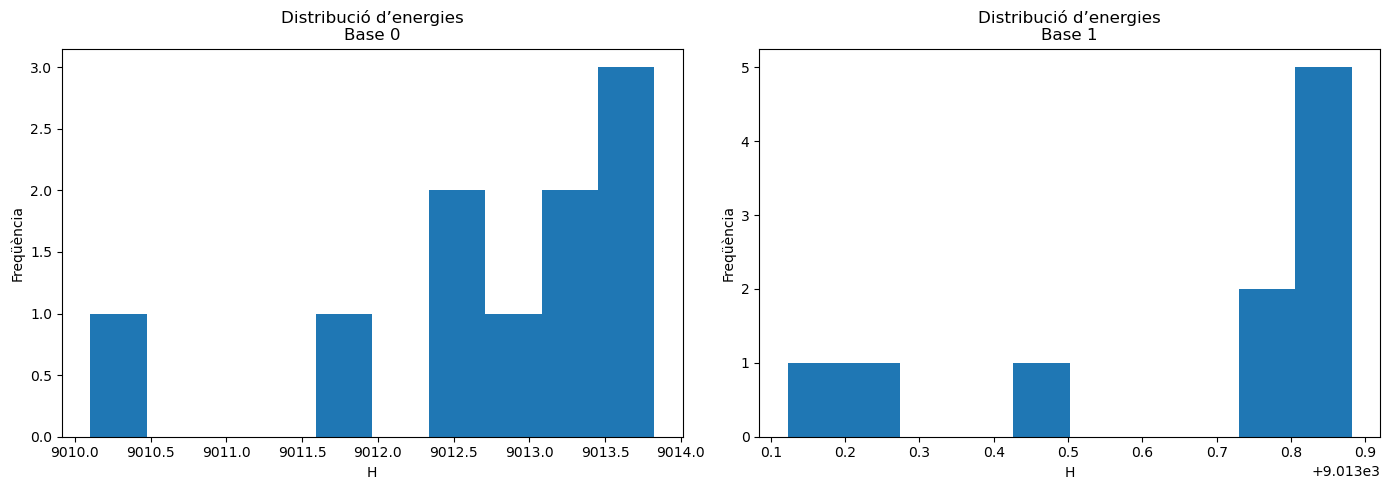

In [22]:
import matplotlib.pyplot as plt
import numpy as np

import numpy as np

np.save("energies_base0.npy", Hs0)
np.save("energies_base1.npy", Hs1)

print("Arxius guardats correctament!")


# Carrega de dades (substitueix per les teves)
energies_base0 = np.load("energies_base0.npy")
energies_base1 = np.load("energies_base1.npy")

plt.figure(figsize=(14, 5))

# --- Subplot Base 0 ---
plt.subplot(1, 2, 1)
plt.hist(energies_base0, bins=10)
plt.xlabel("H")
plt.ylabel("Freqüència")
plt.title("Distribució d’energies\nBase 0")

# --- Subplot Base 1 ---
plt.subplot(1, 2, 2)
plt.hist(energies_base1, bins=10)
plt.xlabel("H")
plt.ylabel("Freqüència")
plt.title("Distribució d’energies\nBase 1")

plt.tight_layout()
plt.show()
